In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import pi, sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training_set')
TEST_DIR = os.path.join(DATA_DIR, 'test_set')

train_df = pd.read_csv(os.path.join(DATA_DIR, 'training_set_pixel_size_and_HC.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_set_pixel_size.csv'))

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 999
Test samples: 335


In [14]:
def ellipse_circumference(a, b):
    h = ((a - b) ** 2) / ((a + b) ** 2)
    return pi * (a + b) * (1 + (3 * h) / (10 + sqrt(4 - 3 * h)))

def get_hc_from_mask(mask, pixel_size):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        return None
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    (_, _), (w, h), _ = cv2.fitEllipse(cnt)
    a, b = max(w, h) / 2, min(w, h) / 2
    return ellipse_circumference(a, b) * pixel_size

---
## Part 1: Machine Learning Approach

Extract image features and use Random Forest for direct HC regression.

In [15]:
def extract_features(img_path, annot_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    annot = cv2.imread(annot_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None or annot is None:
        return None
    
    # Get ellipse params from annotation
    _, binary = cv2.threshold(annot, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 0:
        return None
    
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    
    (cx, cy), (w, h), angle = cv2.fitEllipse(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    # Image stats inside ellipse region
    mask = np.zeros_like(img)
    cv2.ellipse(mask, ((int(cx), int(cy)), (int(w), int(h)), angle), 255, -1)
    roi = img[mask > 0]
    
    features = [
        w, h,                           # ellipse dimensions
        w / h if h > 0 else 1,          # aspect ratio
        area,                           # contour area
        perimeter,                      # contour perimeter
        cx, cy,                         # center position
        roi.mean() if len(roi) > 0 else 0,
        roi.std() if len(roi) > 0 else 0,
    ]
    return features

In [16]:
print("Extracting features...")
features_list = []
targets = []
pixel_sizes = []
valid_files = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = os.path.join(TRAIN_DIR, row['filename'])
    annot_path = os.path.join(TRAIN_DIR, row['filename'].replace('.png', '_Annotation.png'))
    
    feats = extract_features(img_path, annot_path)
    if feats is not None:
        features_list.append(feats + [row['pixel size(mm)']])
        targets.append(row['head circumference (mm)'])
        pixel_sizes.append(row['pixel size(mm)'])
        valid_files.append(row['filename'])

X = np.array(features_list)
y = np.array(targets)
print(f"Valid samples: {len(X)}")

Extracting features...


100%|██████████| 999/999 [00:09<00:00, 108.08it/s]

Valid samples: 999


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_val_scaled)
rf_mae = mean_absolute_error(y_val, y_pred)
print(f"Random Forest MAE: {rf_mae:.4f} mm")

Random Forest MAE: 4.1808 mm


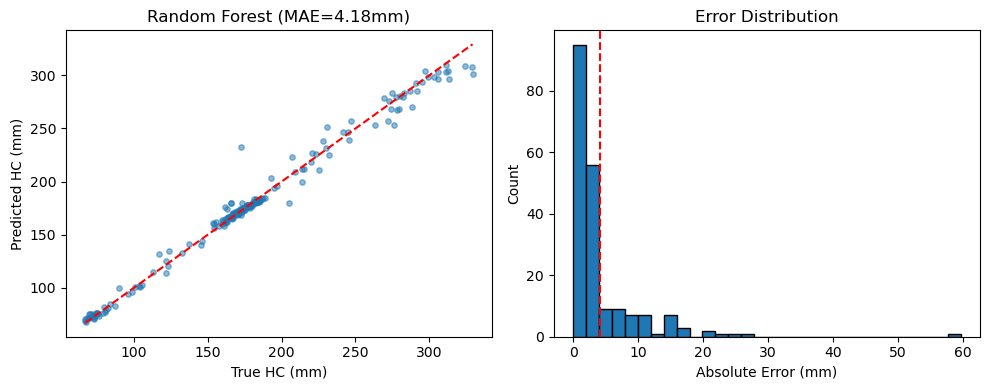

In [18]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred, alpha=0.5, s=15)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True HC (mm)')
plt.ylabel('Predicted HC (mm)')
plt.title(f'Random Forest (MAE={rf_mae:.2f}mm)')

plt.subplot(1, 2, 2)
errors = np.abs(y_val - y_pred)
plt.hist(errors, bins=30, edgecolor='black')
plt.axvline(rf_mae, color='r', linestyle='--')
plt.xlabel('Absolute Error (mm)')
plt.ylabel('Count')
plt.title('Error Distribution')

plt.tight_layout()
plt.savefig('figures/random_forest.pdf', dpi=150, bbox_inches='tight')
plt.show()

---
## Part 2: Deep Learning - U-Net Segmentation

Train U-Net to segment the head, then compute HC from predicted mask.

In [19]:
IMG_SIZE = 256

def fill_ellipse_mask(annot):
    # annotation is just outline, we need to fill it
    _, binary = cv2.threshold(annot, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return binary
    filled = np.zeros_like(annot)
    cv2.drawContours(filled, contours, -1, 255, -1)  # -1 means fill
    return filled

class HCDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = cv2.imread(os.path.join(self.img_dir, row['filename']), 0)
        annot = cv2.imread(os.path.join(self.img_dir, row['filename'].replace('.png', '_Annotation.png')), 0)
        
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        annot = cv2.resize(annot, (IMG_SIZE, IMG_SIZE))
        
        # fill the ellipse
        mask = fill_ellipse_mask(annot)
        
        img = img.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)
        
        img = torch.tensor(img).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)
        
        return img, mask, row['pixel size(mm)'], row['head circumference (mm)']

In [20]:
def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return 1 - (intersection + smooth) / (union + smooth)

def mse_loss(pred, target):
    return nn.MSELoss()(pred, target)

def bce_loss(pred, target):
    return nn.BCELoss()(pred, target)

def bce_iou_loss(pred, target, alpha=0.5):
    return alpha * bce_loss(pred, target) + (1 - alpha) * iou_loss(pred, target)

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        
        # 3-level encoder (reduced to save memory)
        self.enc1 = ConvBlock(in_ch, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(128, 256)
        
        # 3-level decoder
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = ConvBlock(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)
        
        self.out = nn.Conv2d(32, out_ch, 1)
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        
        b = self.bottleneck(self.pool(e3))
        
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return torch.sigmoid(self.out(d1))

In [22]:
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = HCDataset(train_data, TRAIN_DIR)
val_dataset = HCDataset(val_data, TRAIN_DIR)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Train: 799, Val: 200


In [23]:
def train_unet(loss_fn, loss_name, epochs=20):
    # Clear GPU cache before training new model
    torch.cuda.empty_cache()
    
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    best_loss = float('inf')
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for imgs, masks, _, _ in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, masks, _, _ in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                val_loss += loss_fn(outputs, masks).item()
        
        val_losses.append(val_loss / len(val_loader))
        
        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            torch.save(model.state_dict(), f'unet_{loss_name}.pth')
        
        print(f"[{loss_name}] Epoch {epoch+1}/{epochs} - Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")
    
    return model, train_losses, val_losses

In [24]:
# Train with different loss functions
print("Training with MSE Loss...")
model_mse, train_mse, val_mse = train_unet(mse_loss, 'mse', epochs=10)

print("\nTraining with BCE Loss...")
model_bce, train_bce, val_bce = train_unet(bce_loss, 'bce', epochs=10)

print("\nTraining with BCE + IoU Loss...")
model_bce_iou, train_bce_iou, val_bce_iou = train_unet(bce_iou_loss, 'bce_iou', epochs=10)

Training with MSE Loss...
[mse] Epoch 1/10 - Train: 0.0478, Val: 0.0140
[mse] Epoch 2/10 - Train: 0.0101, Val: 0.0087
[mse] Epoch 3/10 - Train: 0.0080, Val: 0.0078
[mse] Epoch 4/10 - Train: 0.0075, Val: 0.0074
[mse] Epoch 5/10 - Train: 0.0071, Val: 0.0071
[mse] Epoch 6/10 - Train: 0.0070, Val: 0.0070
[mse] Epoch 7/10 - Train: 0.0069, Val: 0.0069
[mse] Epoch 8/10 - Train: 0.0068, Val: 0.0068
[mse] Epoch 9/10 - Train: 0.0068, Val: 0.0068
[mse] Epoch 10/10 - Train: 0.0067, Val: 0.0068

Training with BCE Loss...
[bce] Epoch 1/10 - Train: 0.2250, Val: 0.0881
[bce] Epoch 2/10 - Train: 0.0592, Val: 0.0434
[bce] Epoch 3/10 - Train: 0.0381, Val: 0.0335
[bce] Epoch 4/10 - Train: 0.0318, Val: 0.0297
[bce] Epoch 5/10 - Train: 0.0290, Val: 0.0281
[bce] Epoch 6/10 - Train: 0.0273, Val: 0.0271
[bce] Epoch 7/10 - Train: 0.0263, Val: 0.0267
[bce] Epoch 8/10 - Train: 0.0256, Val: 0.0268
[bce] Epoch 9/10 - Train: 0.0252, Val: 0.0263
[bce] Epoch 10/10 - Train: 0.0247, Val: 0.0257

Training with BCE + IoU 

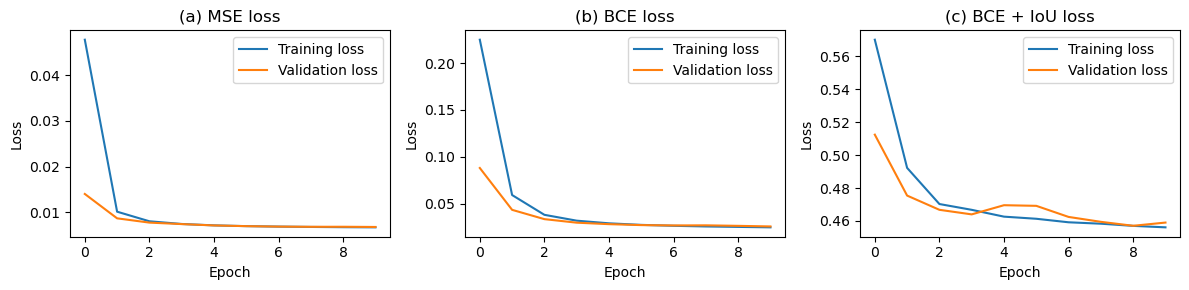

In [25]:
# Plot loss curves for all three models
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(train_mse, label='Training loss')
axes[0].plot(val_mse, label='Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('(a) MSE loss')

axes[1].plot(train_bce, label='Training loss')
axes[1].plot(val_bce, label='Validation loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('(b) BCE loss')

axes[2].plot(train_bce_iou, label='Training loss')
axes[2].plot(val_bce_iou, label='Validation loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].set_title('(c) BCE + IoU loss')

plt.tight_layout()
plt.savefig('figures/loss_curves.pdf', dpi=150)
plt.show()

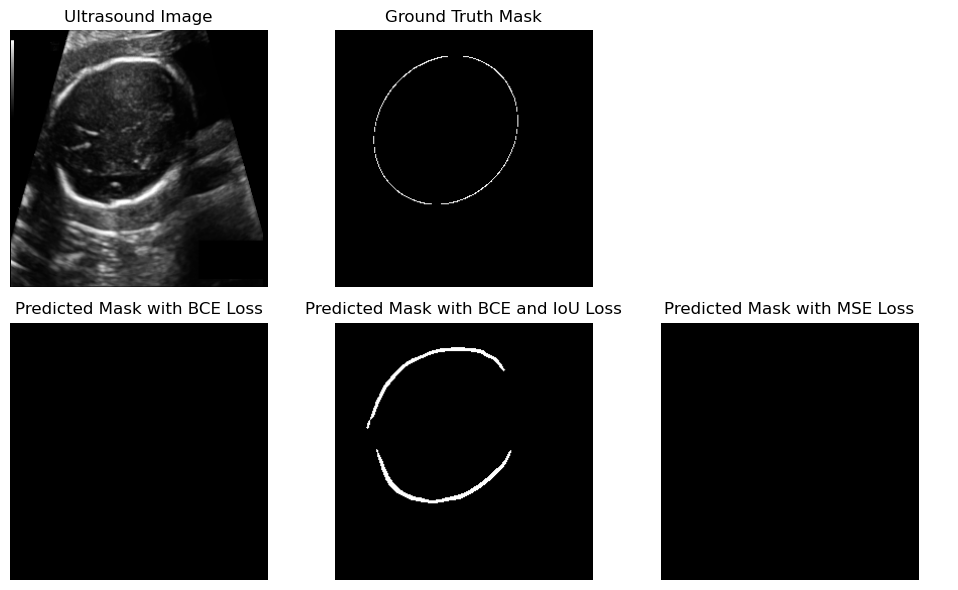

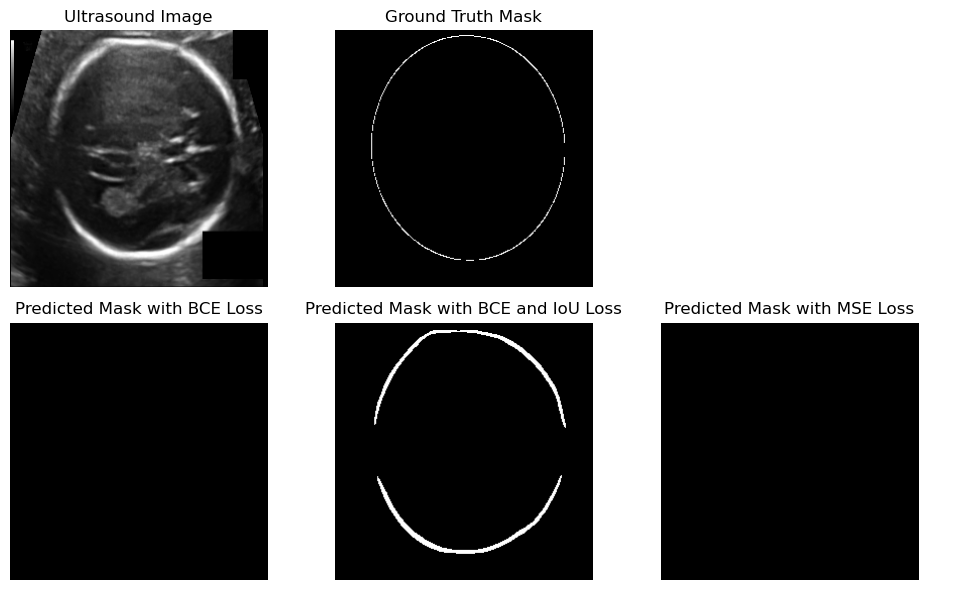

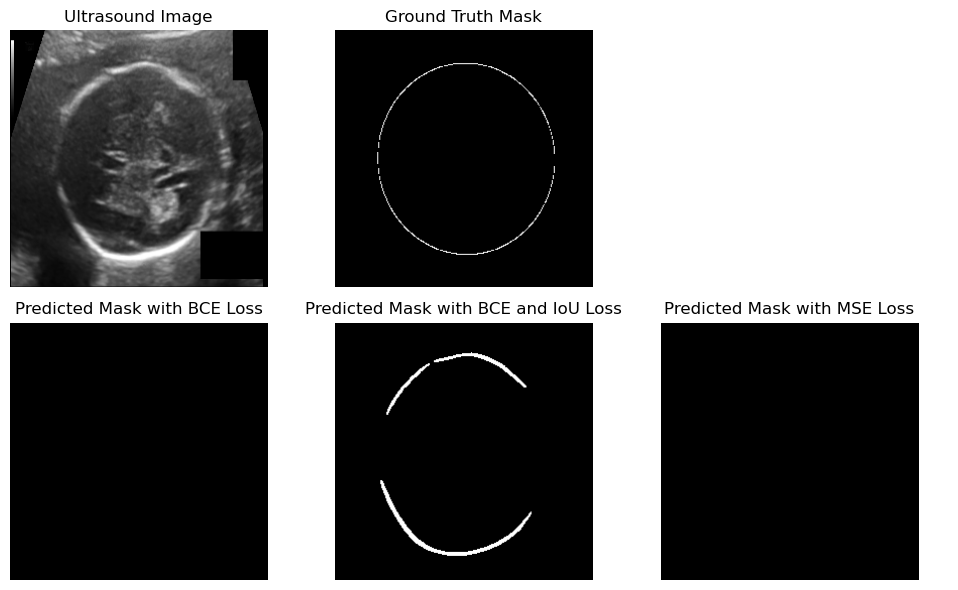

In [29]:
# Load best models
model_mse.load_state_dict(torch.load('unet_mse.pth'))
model_bce.load_state_dict(torch.load('unet_bce.pth'))
model_bce_iou.load_state_dict(torch.load('unet_bce_iou.pth'))

model_mse.eval()
model_bce.eval()
model_bce_iou.eval()

# Visualize predictions from all models
def show_predictions(idx, sample_num):
    img, mask, ps, hc = val_dataset[idx]
    
    with torch.no_grad():
        pred_bce = model_bce(img.unsqueeze(0).to(device)).cpu()
        pred_bce_iou = model_bce_iou(img.unsqueeze(0).to(device)).cpu()
        pred_mse = model_mse(img.unsqueeze(0).to(device)).cpu()
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    
    axes[0, 0].imshow(img[0], cmap='gray')
    axes[0, 0].set_title('Ultrasound Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask[0], cmap='gray')
    axes[0, 1].set_title('Ground Truth Mask')
    axes[0, 1].axis('off')
    
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(pred_bce[0, 0] > 0.5, cmap='gray')
    axes[1, 0].set_title('Predicted Mask with BCE Loss')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(pred_bce_iou[0, 0] > 0.5, cmap='gray')
    axes[1, 1].set_title('Predicted Mask with BCE and IoU Loss')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(pred_mse[0, 0] > 0.5, cmap='gray')
    axes[1, 2].set_title('Predicted Mask with MSE Loss')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'figures/prediction_{sample_num}.pdf', dpi=150)
    plt.show()

# Show 3 sample predictions
for i, idx in enumerate([0, 50, 100]):
    show_predictions(idx, i+1)

In [27]:
def compute_iou(pred, target):
    pred = (pred > 0.5).float().view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection / (union + 1e-6)).item()

def evaluate_model(model, loader, model_name):
    model.eval()
    true_hcs, pred_hcs = [], []
    ious = []
    
    with torch.no_grad():
        sample_idx = 0
        for img, mask, pixel_size, true_hc in loader:
            pred_mask = model(img.to(device)).cpu()
            
            for i in range(len(img)):
                # IoU
                ious.append(compute_iou(pred_mask[i], mask[i]))
                
                # HC from predicted mask
                pm = (pred_mask[i, 0].numpy() > 0.5).astype(np.uint8) * 255
                
                orig_img = cv2.imread(os.path.join(TRAIN_DIR, val_data.iloc[sample_idx]['filename']), 0)
                scale = orig_img.shape[0] / IMG_SIZE
                
                hc_pred = get_hc_from_mask(pm, pixel_size[i].item() * scale)
                
                if hc_pred is not None:
                    true_hcs.append(true_hc[i].item())
                    pred_hcs.append(hc_pred)
                
                sample_idx += 1
    
    mae = mean_absolute_error(true_hcs, pred_hcs) if pred_hcs else float('nan')
    avg_iou = np.mean(ious)
    
    return mae, avg_iou

# Evaluate all models
mae_mse, iou_mse = evaluate_model(model_mse, val_loader, 'MSE')
mae_bce, iou_bce = evaluate_model(model_bce, val_loader, 'BCE')
mae_bce_iou, iou_bce_iou = evaluate_model(model_bce_iou, val_loader, 'BCE+IoU')

print("\nTable 2: MAE and IoU values of U-Net with different loss functions")
print("-" * 45)
print(f"{'Loss function':<15} {'MAE':>12} {'IoU':>12}")
print("-" * 45)
print(f"{'MSE':<15} {mae_mse:>12.4f} {iou_mse:>12.4f}")
print(f"{'BCE':<15} {mae_bce:>12.4f} {iou_bce:>12.4f}")
print(f"{'BCE + IoU':<15} {mae_bce_iou:>12.4f} {iou_bce_iou:>12.4f}")
print("-" * 45)


Table 2: MAE and IoU values of U-Net with different loss functions
---------------------------------------------
Loss function            MAE          IoU
---------------------------------------------
MSE                      nan       0.0000
BCE                      nan       0.0000
BCE + IoU            62.1608       0.1385
---------------------------------------------


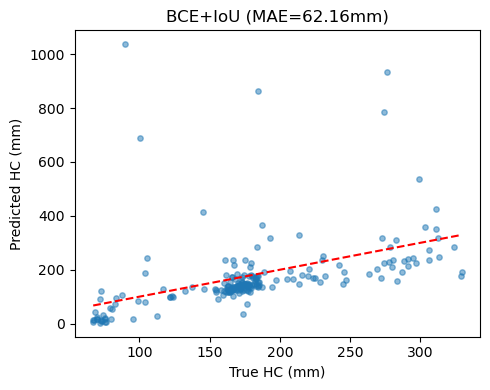

In [32]:
# Scatter plot for BCE + IoU model
fig, ax = plt.subplots(figsize=(5, 4))

true_hcs, pred_hcs = [], []
model_bce_iou.eval()

with torch.no_grad():
    sample_idx = 0
    for img, mask, pixel_size, true_hc in val_loader:
        pred_mask = model_bce_iou(img.to(device)).cpu()
        
        for i in range(len(img)):
            pm = (pred_mask[i, 0].numpy() > 0.5).astype(np.uint8) * 255
            orig_img = cv2.imread(os.path.join(TRAIN_DIR, val_data.iloc[sample_idx]['filename']), 0)
            scale = orig_img.shape[0] / IMG_SIZE
            hc_pred = get_hc_from_mask(pm, pixel_size[i].item() * scale)
            
            if hc_pred is not None:
                true_hcs.append(true_hc[i].item())
                pred_hcs.append(hc_pred)
            sample_idx += 1

if len(true_hcs) > 0:
    ax.scatter(true_hcs, pred_hcs, alpha=0.5, s=15)
    ax.plot([min(true_hcs), max(true_hcs)], [min(true_hcs), max(true_hcs)], 'r--')
    ax.set_xlabel('True HC (mm)')
    ax.set_ylabel('Predicted HC (mm)')
    ax.set_title(f'BCE+IoU (MAE={mae_bce_iou:.2f}mm)')
else:
    ax.set_title('BCE+IoU - No valid predictions')
    ax.text(0.5, 0.5, 'No valid HC\npredictions', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('figures/hc_comparison.pdf', dpi=150)
plt.show()

---
## Summary

In [33]:
print("=" * 50)
print("Results Comparison")
print("=" * 50)
print(f"Random Forest Regression MAE: {rf_mae:.4f} mm")
print("-" * 50)
print("U-Net Segmentation:")
print(f"  MSE Loss     - MAE: {mae_mse:.4f} mm, IoU: {iou_mse:.4f}")
print(f"  BCE Loss     - MAE: {mae_bce:.4f} mm, IoU: {iou_bce:.4f}")
print(f"  BCE+IoU Loss - MAE: {mae_bce_iou:.4f} mm, IoU: {iou_bce_iou:.4f}")
print("=" * 50)

Results Comparison
Random Forest Regression MAE: 4.1808 mm
--------------------------------------------------
U-Net Segmentation:
  MSE Loss     - MAE: nan mm, IoU: 0.0000
  BCE Loss     - MAE: nan mm, IoU: 0.0000
  BCE+IoU Loss - MAE: 62.1608 mm, IoU: 0.1385
